In [9]:
#%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# EC2, eq. (3.14)

sig_c1, sig_c2, sig_c3, eps_cu1, b, c, d, A_f, f_fu, E_f = \
 sp.symbols('sigma_c1 sigma_c2 sigma_c3, varepsilon_cu1, b, c, d, A_f, f_{fu}, E_f', real=True, nonnegative=True)
eps_cy, eps_cu, eps, E_cc, f_cm = \
sp.symbols('varepsilon_cy, varepsilon_cu, varepsilon, E_cc, f_cm', real=True, nonnegative=True)

k = 1.05 * E_cc * eps_cy / f_cm
eta = eps / eps_cy
sig_c = f_cm * (k*eta - eta**2)/(1+eta*(k-2))

sig_c_eps_ = sp.Piecewise(
        (0, eps > eps_cu),
        (sig_c, eps > 0),
        (0, True)
)

In [11]:
from scipy.optimize import minimize

f_cms = np.array([ 20.,  24.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68., 78.,  88.,  98., 108.])

# f_cms = np.array([60])
    
def get_sig_eps(f_cm_, eps_trial_list, branch=1):
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_- 8)
    
    # supress invalid solutions
    for eps_val in eps_trial_list:
        if eps_val < 0 or eps_val > 1:
            return 9999999
        
#     for eps_val in eps_trial_list:
#         if eps_val < 0 or eps_val > eps_cu_:
#             return None
    
    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    if branch == 1:
        eps_fine = np.linspace(0, eps_cy_, 500)
        #     eps_coarse = np.concatenate(([0], [eps_trial_list[0]], [eps_cy_], [eps_trial_list[1]], [eps_cu_]))
        eps_coarse = np.concatenate(([0], [eps_trial_list[0] * eps_cy_], [eps_cy_]))
    elif branch == 2:
        eps_fine = np.linspace(eps_cy_, eps_cu_, 300)
        eps_coarse = np.concatenate(([eps_cy_], [eps_cu_]))
    
    sig_fine = get_sig(eps_fine)
    sig_coarse = get_sig(eps_coarse)
    
    return eps_fine, sig_fine, eps_coarse, sig_coarse

def area_diff_eps_mini(eps_trial_list, f_cm_=None, branch=1):
    eps_sig = get_sig_eps(f_cm_, eps_trial_list, branch)
    if eps_sig is None:
        return 99999999
    eps_fine, sig_fine, eps_coarse, sig_coarse = eps_sig
    area_diff = np.abs(np.trapz(y=sig_fine, x=eps_fine) - np.trapz(y=sig_coarse, x=eps_coarse))

    return area_diff

def area_diff_sig_scale_mini(sig_scales, eps_trial_list=None, f_cm_=None, branch=1):
    for sig_scale in sig_scales:
        if sig_scale < 0 or sig_scale > 10:
            return 9999999
    
    eps_fine, sig_fine, eps_coarse, sig_coarse = get_sig_eps(f_cm_, eps_trial_list, branch)
    if branch == 1:
        sig_coarse[1] *= sig_scales[0]
        if sig_coarse[1] > f_cm_:
            return 9999999
    elif branch == 2:
        sig_coarse[-1] *= sig_scales[0]
        if sig_coarse[-1] > f_cm_:
            return 9999999

    area_diff = np.abs(np.trapz(y=sig_fine, x=eps_fine) - np.trapz(y=sig_coarse, x=eps_coarse))
    
#     print('area_diff=', area_diff)
    return area_diff
 

c_section, b_section = 150, 400

def minimize_area_diff():
    result = np.zeros((len(f_cms), 4))
    
    # branch 1
    for i, f_cm_ in enumerate(f_cms):
        branch = 1 
        res1 = minimize(area_diff_eps_mini, np.array([0]), tol=1e-12, args=(f_cm_, branch))
        smallest_diff1 = res1.fun
        print('smallest_diff1=', smallest_diff1)
        print('F_c_diff [N] ≈', np.round(smallest_diff1 * (c_section / EC2.get_eps_cu1(f_cm_ - 8)) * b_section, 3))
        
        res2 = minimize(area_diff_sig_scale_mini, np.array([1.]), tol=1e-12, args=(np.sort(res1.x), f_cm_, branch))
        smallest_diff2 = res2.fun
        print('smallest_diff2=', smallest_diff2)
        print('F_c_diff [N] ≈', np.round(smallest_diff2 * (c_section / EC2.get_eps_cu1(f_cm_ - 8)) * b_section, 3))
        
        branch = 2
        res3 = minimize(area_diff_sig_scale_mini, np.array([1.]), tol=1e-12, args=(np.sort(res1.x), f_cm_, branch))
        smallest_diff3 = res3.fun
        print('smallest_diff3=', smallest_diff3)
        print('F_c_diff [N] ≈', np.round(smallest_diff2 * (c_section / EC2.get_eps_cu1(f_cm_ - 8)) * b_section, 3))
        
        print('-----------------------------')
        sol1 = res1.x
        sol2 = res2.x
        sol3 = res3.x
        print(sol1)
        result[i:] = np.concatenate(([f_cm_], np.sort(sol1), np.sort(sol2), np.sort(sol3)))
    return result

result = minimize_area_diff()
result

smallest_diff1= 0.0017845824085170568
F_c_diff [N] ≈ 30592.841
smallest_diff2= 9.755401694788723e-11
F_c_diff [N] ≈ 0.002
smallest_diff3= 6.830130905299825e-11
F_c_diff [N] ≈ 0.002
-----------------------------
[0.44789506]
smallest_diff1= 0.0021539913118004753
F_c_diff [N] ≈ 36925.565
smallest_diff2= 1.252167119991654e-10
F_c_diff [N] ≈ 0.002
smallest_diff3= 4.294761074552511e-11
F_c_diff [N] ≈ 0.002
-----------------------------
[0.46287631]
smallest_diff1= 0.0025131189684338417
F_c_diff [N] ≈ 43082.039
smallest_diff2= 1.4515779550583474e-10
F_c_diff [N] ≈ 0.002
smallest_diff3= 4.427858774080917e-11
F_c_diff [N] ≈ 0.002
-----------------------------
[0.47622923]
smallest_diff1= 0.002945016590974736
F_c_diff [N] ≈ 50485.999
smallest_diff2= 1.7022202397631858e-10
F_c_diff [N] ≈ 0.003
smallest_diff3= 2.4636681583700692e-11
F_c_diff [N] ≈ 0.003
-----------------------------
[0.4912546]
smallest_diff1= 0.0033558458456816667
F_c_diff [N] ≈ 57528.786
smallest_diff2= 5.839509431559975e-11
F_

array([[ 20.        ,   0.44789506,   1.13381005,   1.25393379],
       [ 24.        ,   0.46287631,   1.12742087,   1.2521215 ],
       [ 28.        ,   0.47622923,   1.12161289,   1.24830095],
       [ 33.        ,   0.4912546 ,   1.11499021,   1.24152433],
       [ 38.        ,   0.50490385,   1.10892868,   1.23315806],
       [ 43.        ,   0.51751462,   1.10331766,   1.22365821],
       [ 48.        ,   0.52931887,   1.09807755,   1.21334235],
       [ 53.        ,   0.54048383,   1.09314897,   1.20244302],
       [ 58.        ,   0.55113477,   1.0884863 ,   1.19113778],
       [ 63.        ,   0.56136872,   1.08405368,   1.06009764],
       [ 68.        ,   0.57126297,   1.07982235,   1.02116994],
       [ 78.        ,   0.59027457,   1.07187387,   1.00208012],
       [ 88.        ,   0.60925116,   1.0642266 ,   1.00000075],
       [ 98.        ,   0.64275529,   1.0515758 ,   1.        ],
       [108.        ,   0.67931527,   1.03922995,   1.        ]])

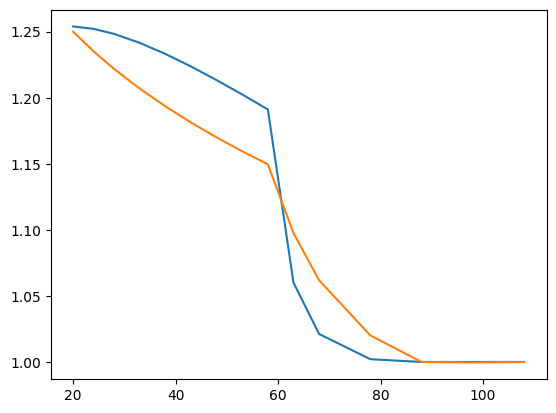

In [12]:
fig1, ax1 = plt.subplots()
eps_diff = np.zeros(len(f_cms))
for i, f_cm_val in enumerate(f_cms):
#     eps_diff[i] = (3.5 if f_cm_val <50 else 2.8 + 27 * ((98 - f_cm_val) / 100) ** 4) - min(2.8, 0.7 * f_cm_val ** 0.31)
    eps_diff[i] = EC2.get_eps_cu1(f_cm_val - 8) - EC2.get_eps_c1(f_cm_val - 8)

eps_diff_scaled = (eps_diff - eps_diff[0])/(eps_diff[-1] - eps_diff[0]) * (1 - 1.25) + 1.25

ax1.plot(result[:, 0], result[:, 3]) # sig_eps_cu_scaled / sig_eps_cu_exact
ax1.plot(result[:, 0], eps_diff_scaled)
# ax1.plot(result[:, 0], sig_eps_cu_scaled)

In [13]:
m1, p1 = np.polyfit(result[:, 0], result[:, 1], 1)
eps_cy_p1_scale = m1 * f_cm + p1 # must be <= 1

m2, p2 = np.polyfit(result[:, 0], result[:, 2], 1)
sig_cy_p1_scale = m2 * f_cm + p2  # must be >= 1

sig_eps_cu_scaled = 1.000964 + (1.235655 - 1.000964)/(1 + (f_cm/60.73773)**24.71828) # must be >= 1
# last one obtained from https://mycurvefit.com/, by 4PL Symmetrical sigmoidal fitting

In [14]:
get_eps_cy_p1_scale = sp.lambdify(f_cm, eps_cy_p1_scale, 'numpy')
get_sig_cy_p1_scale = sp.lambdify(f_cm, sig_cy_p1_scale, 'numpy')

Text(0, 0.5, 'sig_cy_p1_scale')

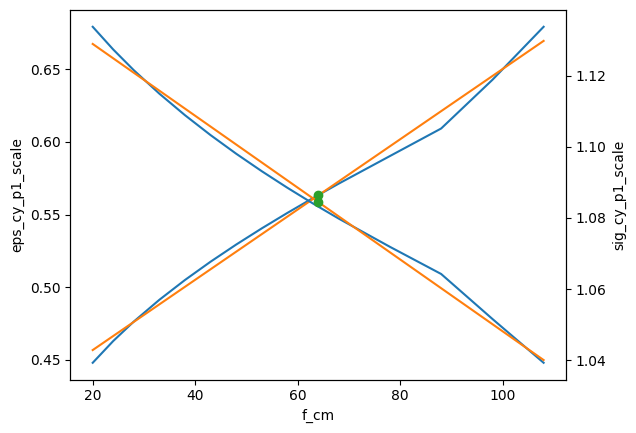

In [15]:
fig1, ax1 = plt.subplots()
f_cm_mid = (result[:, 0][-1] + result[:, 0][0])/2
ax1.set_xlabel('f_cm')
ax1.set_ylabel('eps_cy_p1_scale')

ax1.plot(result[:, 0], result[:, 1]) # eps_cy_p1_scale / eps_cy
ax1.plot(result[:, 0], get_eps_cy_p1_scale(result[:, 0]))
eps_cy_p1_scale_mid = np.interp(f_cm_mid, result[:, 0], get_eps_cy_p1_scale(result[:, 0]))
ax1.plot(f_cm_mid, eps_cy_p1_scale_mid, 'o')

ax2 = ax1.twinx()
ax2.plot(result[:, 0], result[:, 2]) # sig_cy_p1_scale, (sig_cy_p1_scaled = sig_cy_p1_scale * sig_cy_p1_exact)
ax2.plot(result[:, 0], get_sig_cy_p1_scale(result[:, 0]))
sig_cy_p1_scale_mid = np.interp(f_cm_mid, result[:, 0], get_sig_cy_p1_scale(result[:, 0]))
ax2.plot(f_cm_mid, sig_cy_p1_scale_mid, 'o')
ax2.set_ylabel('sig_cy_p1_scale')

# ax1.plot(result[:, 0], result[:, 3]) # sig_eps_cu_scale, (sig_eps_cu_scaled = sig_eps_cu_scale * sig_eps_cu_exact)

In [16]:
eps_cy_p1_scale_mid, sig_cy_p1_scale_mid # Use these, easier than doing a linear equation

(0.5631233574913839, 1.0844887177047342)

0.00018346401178581662
F_c_diff [kN] ≈ 3.65
F_c_diff [%] ≈ 0.13


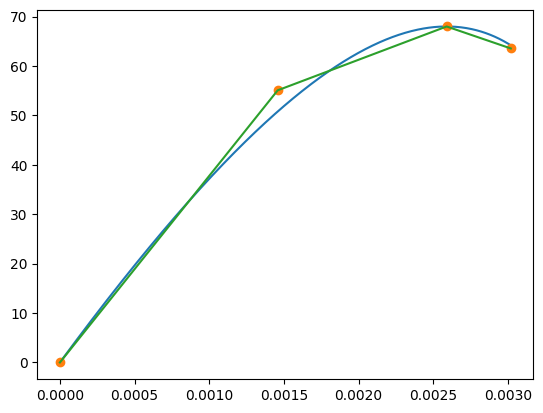

In [17]:
fig, ax = plt.subplots()

for f_cm_ in [68]: # f_cms:
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_ - 8)

    eps_fine = np.linspace(0, eps_cu_, 500)

    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})

    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    sig_fine = get_sig(eps_fine)

    
    ax.plot(eps_fine, sig_fine)
    
    result_for_f_ck = np.copy(result[np.argwhere(result[:, 0]==f_cm_)[0][0]])
    result_for_f_ck[1] = eps_cy_p1_scale_mid
    result_for_f_ck[2] = sig_cy_p1_scale_mid
    
    eps_coarse = np.concatenate(([0], [result_for_f_ck[1] * eps_cy_], [eps_cy_], [eps_cu_]))
    sig_coarse = get_sig(eps_coarse)

#     result_for_f_ck[3] = (sig_coarse[-2] + sig_coarse[-1]) / 2

    sig_coarse[1] *= result_for_f_ck[2]
    sig_coarse[-1] = (sig_coarse[-2] + sig_coarse[-1]) / 2.08 

    ax.plot(eps_coarse, sig_coarse, 'o')
    ax.plot(eps_coarse, sig_coarse)
    
    area_diff = np.abs(np.trapz(y=sig_fine, x=eps_fine) - np.trapz(y=sig_coarse, x=eps_coarse))
    print(area_diff)
    c, b = 150, 400
    F_c_diff = np.round(area_diff * (c / EC2.get_eps_cu1(f_cm_ - 8)) * b/1000, 2)
    F_c_total = np.trapz(y=sig_fine, x=eps_fine) * (c / EC2.get_eps_cu1(f_cm_ - 8)) * b/1000
    print('F_c_diff [kN] ≈', F_c_diff)
    print('F_c_diff [%] ≈', np.round(100 * F_c_diff/F_c_total, 2))
    

# fig.show()

## Deriving equations for the three linearized parts
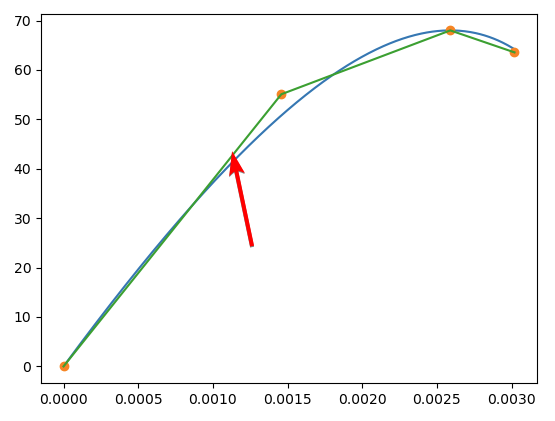

In [18]:
substitute_E_cc_and_eps_cy = False

if substitute_E_cc_and_eps_cy:
    E_cm = 22000 * (f_cm / 10) ** 0.3
    # WARNING, TODO: Instead use 0.001 * sp.Min(0.7 * f_cm ** 0.31, 2.8) ??
    eps_c1 = 0.001 * 0.7 * f_cm ** 0.31
else:
    E_cm = E_cc
    eps_c1 = eps_cy
    
# eps_cy_p1 = eps_cy_p1_scale * eps_c1
eps_cy_p1 = eps_cy_p1_scale_mid * eps_c1

sig_cy_p1 = sp.simplify(sig_c.subs({eps:eps_cy_p1, E_cc:E_cm, eps_cy:eps_c1}))

# sig_cy_p1 =  sig_cy_p1_scale * sig_cy_p1
sig_cy_p1 = sig_cy_p1_scale_mid * sig_cy_p1
sig_cy_p1

1.08448871770473*f_cm*(0.591279525365953*E_cc*varepsilon_cy - 0.317107915752369*f_cm)/(0.591279525365953*E_cc*varepsilon_cy - 0.126246714982768*f_cm)

In [19]:
eps_cy_p1_scale.subs({f_cm:100})

0.650234113129353

In [20]:
sig_c_part_1_line = sp.Line(sp.Point(0, 0), sp.Point(eps_cy_p1, sig_cy_p1))

sig_c1_eq = sig_c_part_1_line.equation(x=eps, y=sig_c1)
sig_c1_ = sp.solve(sig_c1_eq, sig_c1)[0]
sig_c1_

542244358852365*f_cm*varepsilon*(591279525365953*E_cc*varepsilon_cy - 317107915752369*f_cm)/(281561678745692*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm))

In [21]:
sig_c2_line = sp.Line(sp.Point(eps_cy_p1, sig_cy_p1), sp.Point(eps_c1, f_cm))
sig_c2_eq = sig_c2_line.equation(x=eps, y=sig_c2)
sig_c2_ = sp.solve(sig_c2_eq, sig_c2)[0]
sig_c2_

f_cm*(-24978224451615372181724528845*E_cc*varepsilon*varepsilon_cy + 154136331364598169603402304369*E_cc*varepsilon_cy**2 + 108826620972769103994370002685*f_cm*varepsilon - 136403741457476039440735767229*f_cm*varepsilon_cy)/(218438321254308*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm))

In [22]:
sig_cy_p3 = sp.simplify(sig_c.subs({eps:eps_cu1, E_cc:E_cm, eps_cy:eps_c1}))
sig_cy_p3 = (sig_cy_p3 + f_cm) / 2.08
sig_cy_p3

0.480769230769231*f_cm*varepsilon_cu1*(1.05*E_cc*varepsilon_cy**2 - f_cm*varepsilon_cu1)/(varepsilon_cy*(f_cm*varepsilon_cy + varepsilon_cu1*(1.05*E_cc*varepsilon_cy - 2*f_cm))) + 0.480769230769231*f_cm

In [23]:
sig_c3_line = sp.Line(sp.Point(eps_c1, f_cm), sp.Point(eps_cu1, sig_cy_p3))

sig_c3_eq = sig_c3_line.equation(x=eps, y=sig_c3)
sig_c3_ = sp.solve(sig_c3_eq, sig_c3)[0]
sig_c3_

f_cm*(-21*E_cc*varepsilon*varepsilon_cu1*varepsilon_cy**2 + 546*E_cc*varepsilon_cu1**2*varepsilon_cy**2 - 525*E_cc*varepsilon_cu1*varepsilon_cy**3 - 250*f_cm*varepsilon*varepsilon_cu1**2 + 540*f_cm*varepsilon*varepsilon_cu1*varepsilon_cy - 270*f_cm*varepsilon*varepsilon_cy**2 - 790*f_cm*varepsilon_cu1**2*varepsilon_cy + 1020*f_cm*varepsilon_cu1*varepsilon_cy**2 - 250*f_cm*varepsilon_cy**3)/(26*varepsilon_cy*(21*E_cc*varepsilon_cu1**2*varepsilon_cy - 21*E_cc*varepsilon_cu1*varepsilon_cy**2 - 40*f_cm*varepsilon_cu1**2 + 60*f_cm*varepsilon_cu1*varepsilon_cy - 20*f_cm*varepsilon_cy**2))

In [24]:
eq = sp.Piecewise(
    (sig_c1_, eps <= eps_cy_p1), 
    (sig_c2_, eps <= eps_c1), 
    (sig_c3_, True)
)
eq

Piecewise((542244358852365*f_cm*varepsilon*(591279525365953*E_cc*varepsilon_cy - 317107915752369*f_cm)/(281561678745692*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm)), varepsilon <= 0.563123357491384*varepsilon_cy), (f_cm*(-24978224451615372181724528845*E_cc*varepsilon*varepsilon_cy + 154136331364598169603402304369*E_cc*varepsilon_cy**2 + 108826620972769103994370002685*f_cm*varepsilon - 136403741457476039440735767229*f_cm*varepsilon_cy)/(218438321254308*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm)), varepsilon <= varepsilon_cy), (f_cm*(-21*E_cc*varepsilon*varepsilon_cu1*varepsilon_cy**2 + 546*E_cc*varepsilon_cu1**2*varepsilon_cy**2 - 525*E_cc*varepsilon_cu1*varepsilon_cy**3 - 250*f_cm*varepsilon*varepsilon_cu1**2 + 540*f_cm*varepsilon*varepsilon_cu1*varepsilon_cy - 270*f_cm*varepsilon*varepsilon_cy**2 - 790*f_cm*varepsilon_cu1**2*varepsilon_cy + 1020*f_cm*varepsilon_cu1*varepsilon_cy**2 - 250*f_cm*varepsilon_cy**3)/(26*varepsilon

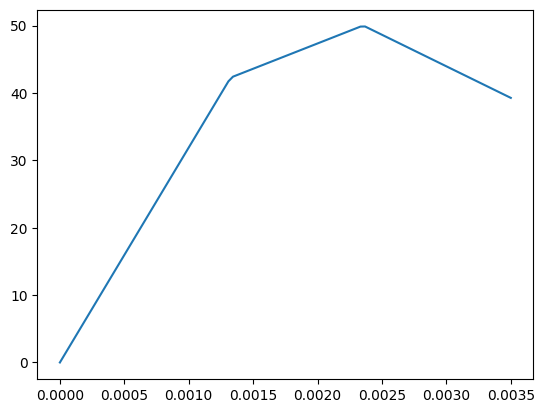

In [25]:
get_eq = sp.lambdify(eps, eq.subs({f_cm:50, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8), eps_cu1:EC2.get_eps_cu1(50-8)}), 'numpy')
eps_vals = np.linspace(0, EC2.get_eps_cu1(50-8), 100)
sig_vals = get_eq(eps_vals)
fig4, ax4 = plt.subplots()
ax4.plot(eps_vals, sig_vals)

In [26]:
np.trapz(y=sig_vals, x=eps_vals)

0.1266139414828207

In [27]:
eq_area = sp.integrate(sp.simplify(eq), eps)
eq_area

Piecewise((varepsilon**2*(320617987134591872181724528845*E_cc*f_cm*varepsilon_cy - 171949978464153103994370002685*f_cm**2)/(332963311539987405156644448952*E_cc*varepsilon_cy**2 - 71092474013354129107268470912*f_cm*varepsilon_cy), varepsilon <= 0.563123357491384*varepsilon_cy), (varepsilon**2*(-24978224451615372181724528845*E_cc*f_cm*varepsilon_cy + 108826620972769103994370002685*f_cm**2)/(258316213825965594843355551048*E_cc*varepsilon_cy**2 - 55154240969413870892731529088*f_cm*varepsilon_cy) + varepsilon*(154136331364598169603402304369*E_cc*f_cm*varepsilon_cy - 136403741457476039440735767229*f_cm**2)/(129158106912982797421677775524*E_cc*varepsilon_cy - 27577120484706935446365764544*f_cm) + 0.317107915752369*varepsilon_cy**2*(320617987134591872181724528845*E_cc*f_cm*varepsilon_cy - 171949978464153103994370002685*f_cm**2)/(332963311539987405156644448952*E_cc*varepsilon_cy**2 - 71092474013354129107268470912*f_cm*varepsilon_cy) - 0.317107915752369*varepsilon_cy**2*(-24978224451615372181724

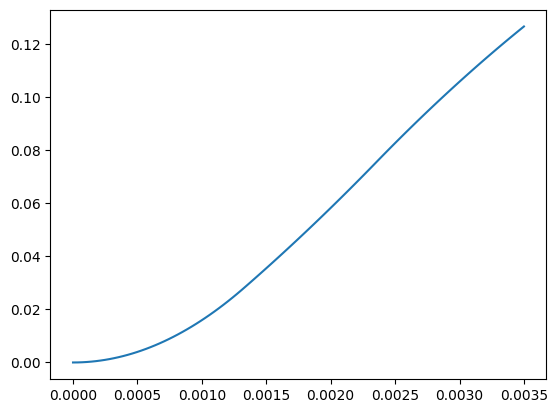

In [28]:
get_eq_area = sp.lambdify(eps, eq_area.subs({f_cm:50, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8), eps_cu1:EC2.get_eps_cu1(50-8)}), 'numpy')
eps_vals2 = np.linspace(0, EC2.get_eps_cu1(50-8), 100)
sig_vals2 = get_eq_area(eps_vals2)
fig4, ax4 = plt.subplots()
ax4.plot(eps_vals2, sig_vals2)

In [29]:
sig_1_area_up_to_eps = eq_area.args[0][0]
sig_2_area_up_to_eps = eq_area.args[1][0]
sig_3_area_up_to_eps = eq_area.args[2][0]
sig_1_area_up_to_eps

varepsilon**2*(320617987134591872181724528845*E_cc*f_cm*varepsilon_cy - 171949978464153103994370002685*f_cm**2)/(332963311539987405156644448952*E_cc*varepsilon_cy**2 - 71092474013354129107268470912*f_cm*varepsilon_cy)

In [30]:
# Compare F_t = A_f * f_fu with F_c_1, if F_t <= F_c_1, then you can use sig_c_part_1
eps_fu = f_fu/E_f
c_1 = d * (eps_cy_p1 / (eps_cy_p1 + eps_fu))
F_c_1 = sig_1_area_up_to_eps.subs({eps:eps_cy_p1}) * (c_1 / eps_cy_p1) * b
F_c_1 = sp.simplify(F_c_1)
F_c_1

122.140185575083*E_f*d*f_cm*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 317107915752369*f_cm)/((591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm)*(0.563123357491384*E_f*varepsilon_cy + f_{fu}))

In [31]:
20*2500

50000

In [32]:
sp.N(F_c_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}))

145916.655687362

In [33]:
# Compare F_t = A_f * f_fu with F_c_1, if F_t <= F_c_1, then you can use sig_c_part_1
eps_fu = f_fu/E_f
c_2 = d * (eps_c1 / (eps_c1 + eps_fu))
F_c_2 = sig_2_area_up_to_eps.subs({eps:eps_c1}) * (c_2 / eps_c1) * b
F_c_2 = sp.simplify(F_c_2)
F_c_2

# You don't need F_c_3 because if F_t > F_c_2, then the user will use last equation directly

25*E_f*d*f_cm*varepsilon_cy*(2.41706075164683e+58*E_cc*varepsilon_cy - 1.07224266950086e+58*f_cm)/(3358700006006714853162058335147942217103472*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm)*(E_f*varepsilon_cy + f_{fu}))

In [34]:
# Solving eps top for part 1
def get_eps_top_solved(index):
    c = d * eps/(eps + eps_fu)

    F_t = A_f * f_fu
    sig_z_area = eq_area.args[index][0] * (c / eps)
    F_c = sig_z_area * b
    eps_top_solved = sp.solve(F_t - F_c, eps)[1] # TODO, this the positive solution, make sure you don't want the negative
    eps_top_solved = sp.simplify(eps_top_solved)
    return eps_top_solved

In [35]:
eps_part_1 = get_eps_top_solved(0)
eps_part_1

f_{fu}*(sqrt(70390419686423)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(24609298601454961771874536406189351728416407*A_f*E_cc**2*E_f*varepsilon_cy**3 - 10508881072926844314485839784378973883914784*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1121898913022969927410051090367075473655552*A_f*E_f*f_cm**2*varepsilon_cy + 37914970251345741499667218499367807025882857000*E_cc**2*d*f_cm*varepsilon_cy**2 - 28429493858619976980059647277611145462305353000*E_cc*d*f_cm**2*varepsilon_cy + 4341623984491406521489661009098289177746416000*d*f_cm**3) + 70390419686423*A_f*sqrt(E_f)*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm))/(54224435885236500*sqrt(E_f)*d*f_cm*(591279525365953*E_cc*varepsilon_cy - 317107915752369*f_cm))

In [36]:
def get_psi(index):
    if index >= 2:
        return 1
    else:
        eps_top_solved = get_eps_top_solved(index)
        sig_c_eq = eq.args[index][0]
        f_c_max = sig_c_eq.subs({eps: eps_top_solved})
        psi_c = f_c_max/f_cm
        psi_c = sp.simplify(psi_c)
        return psi_c

In [37]:
psi_c_part_1 = get_psi(0)
# sp.cse(psi_c_part_1)
psi_c_part_1

f_{fu}*(sqrt(70390419686423)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(24609298601454961771874536406189351728416407*A_f*E_cc**2*E_f*varepsilon_cy**3 - 10508881072926844314485839784378973883914784*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1121898913022969927410051090367075473655552*A_f*E_f*f_cm**2*varepsilon_cy + 37914970251345741499667218499367807025882857000*E_cc**2*d*f_cm*varepsilon_cy**2 - 28429493858619976980059647277611145462305353000*E_cc*d*f_cm**2*varepsilon_cy + 4341623984491406521489661009098289177746416000*d*f_cm**3) + 70390419686423*A_f*sqrt(E_f)*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm))/(28156167874569200*sqrt(E_f)*d*f_cm*varepsilon_cy*(591279525365953*E_cc*varepsilon_cy - 126246714982768*f_cm))

In [38]:
sp.N(psi_c_part_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}))

0.484722258874583

In [39]:
# Because first part is triangle, the center of it is
ce1 = c.subs({eps: eps_part_1}) / 3
ce1 = sp.simplify(ce1)
ce1

AttributeError: 'int' object has no attribute 'subs'

In [ ]:
M_n_1 = sp.simplify(A_f * f_fu * (d - ce1))
M_n_1
# packaging common terms
# sp.cse(M_n)

In [ ]:
sp.N(M_n_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}) / 1e6)

In [ ]:
# Not solvable directly if eps_cy and E_cc are substituted, it's solved below, but it's very complex formula!
psi_c_part_2 = get_psi(1)
psi_c_part_2

In [ ]:
psi_c_part_2_reduced = sp.cse(psi_c_part_2)
psi_c_part_2_reduced

In [ ]:
psi_c_part_3 = get_psi(2)
psi_c_part_3

## Solving psi and Mn for part 2 if it's not solvable because eps_cy and E_cc are substituted

In [ ]:
eps_part_2 = get_eps_top_solved(1)
eps_part_2

In [ ]:
c = d * eps/(eps + eps_fu)

F_t = A_f * f_fu
sig_z_area = eq_area.args[1][0] * (c / eps)
factors, sig_z_area = sp.cse(sig_z_area)[:-1][0], sp.cse(sig_z_area)[-1][0]
sig_z_area

In [ ]:
F_c = sig_z_area * b
eps_top_solved = sp.solve(F_t - F_c, eps)[0] # TODO, this the positive solution, make sure you don't want the negative
eps_top_solved

In [ ]:
sig_c_eq = eq.args[1][0]
f_c_max = sig_c_eq.subs({eps: eps_top_solved})
psi_c = f_c_max/f_cm
psi_c

In [ ]:
# substitute factors in each others
# convert factors list of tuples to list of lists so that expressions can be modified

factors = [[symb, value] for (symb, value) in factors]
for i in range(len(factors)):
    factors[i][1] = factors[i][1].subs({symb:value for (symb, value) in factors})
factors

In [ ]:
psi_c = psi_c.subs({symb:value for (symb, value) in factors})
psi_c = sp.simplify(psi_c)
psi_c

In [ ]:
psi_c_reduced = sp.cse(psi_c)
psi_c_reduced[-1][0]